# Business Problem

With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company or a person's brand for being viral (positive) or devastate profit because it strikes a negative tone. Capturing sentiment in language is important in these times where decisions and reactions are created and updated in seconds. But which words actually lead to the sentiment description? In this problem we need to pick out the part of the tweet (word or phrase) that reflects the sentiment.

# Source of Data

Source of Data
It is a Kaggle competition.In this competition we have extracted support phrases from Figure Eight's Data for Everyone platform.Data is available here
https://www.kaggle.com/c/tweet-sentiment-extraction/data


# Data Overview

It consists of two data files.train.csv with 27481 rows and test.csv with 3534 rows.

List of columns in the dataset :

textID: unique id for each row of data.

text: contains text data of the tweet.

sentiment: sentiment of the text (positive/negative/neutral).

selected_text: phrases /words from the text that best supports the sentiment.

# Mapping real world problem with ML/DL problem

Input given to model is a sentence and output will be the phrase/word which is part of input itself. That is we have to predict the word or phrase from the tweet that exemplifies the provided sentiment. For example

Sentence: So sad I will miss you here in San Diego.

Sentiment: negative

Output: So sad

# Performance Metrics

The metric in this problem is the word-level Jaccard score. Jaccard Score or Jaccard Similarity is defined as size of intersection divided by size of union of two sets.

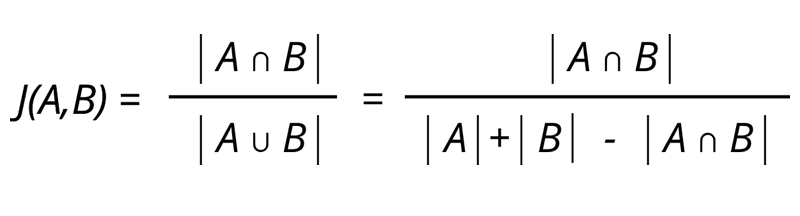


Let's see the example how Jaccard Similarity work?

doc_1 = "Data is the new oil of the digital economy"

doc_2 = "Data is a new oil"

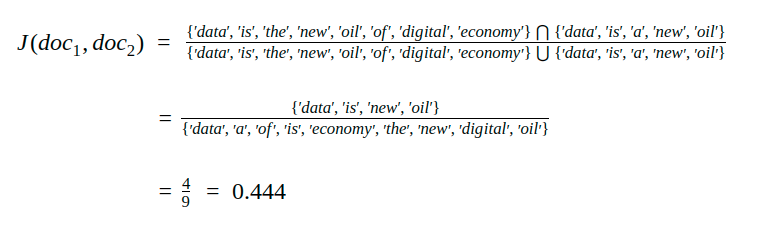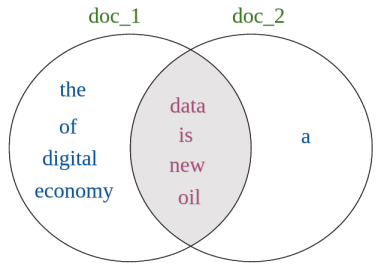

In [8]:
import pandas as pd
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings("ignore")
import string
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud,STOPWORDS
# load in all the modules we're going to need
import nltk, re, string, collections
from nltk.util import ngrams # function for making ngrams
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from nltk.stem.porter import PorterStemmer
import tensorflow as tf
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.layers.core import Dense,Activation,Dropout
from keras.layers.embeddings import Embedding

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Exploratory Data Analysis

In [10]:
train=pd.read_csv('/content/drive//My Drive/Tweet Sentiment Extraction/train.csv')
test=pd.read_csv('/content/drive//My Drive/Tweet Sentiment Extraction/test.csv')

In [11]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [12]:
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [13]:
print("train shape :",train.shape)
print("test shape :",test.shape)

train shape : (27481, 4)
test shape : (3534, 3)


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [15]:
train.dropna(inplace=True)

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [17]:
def patch1(bar,ax):
  #https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib
  for p in bar.patches: 
     width=p.get_width()
     height=p.get_height()
     x,y=p.get_xy() 
     ax.annotate('{}'.format(height),(x+width/2,y+height*1.02),ha='center',fontsize=14)

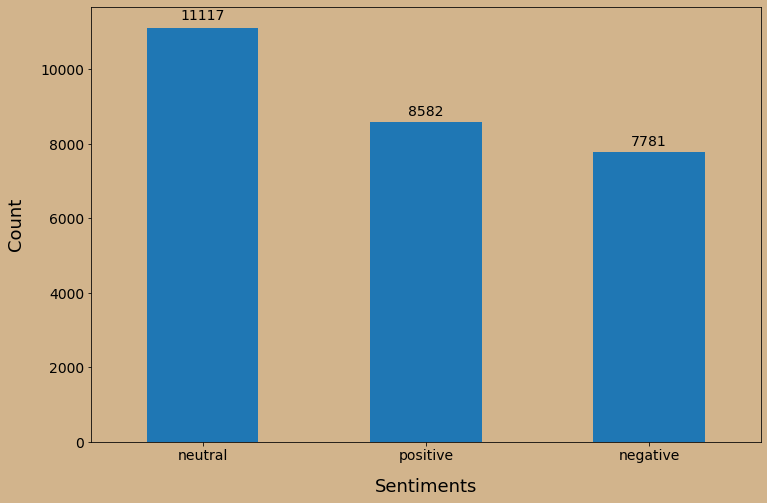

In [18]:
fig,ax=plt.subplots(figsize=(12,8))
a=train['sentiment'].value_counts().plot(kind='bar')
patch1(a,ax) 
ax.set_xlabel("Sentiments",fontsize=18,labelpad=15)
ax.set_ylabel("Count",fontsize=18,labelpad=15)
plt.xticks(rotation='horizontal',fontsize=14)
plt.yticks(fontsize=14)
ax.set_facecolor("tan")
fig.set_facecolor("tan")
plt.show()

* No. of neutral tweets : 11117

* No. of positive tweets : 8582

* No. of negative tweets : 7781





In [20]:
train['sentiment'].value_counts(normalize=True)

neutral     0.404549
positive    0.312300
negative    0.283151
Name: sentiment, dtype: float64

* About 40 percent of the tweets are neutral followed by positive and negative tweets.

In [21]:
#https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/

train['text']= train['text'].apply(lambda x: x.lower())
train['selected_text']= train['selected_text'].apply(lambda x: x.lower())

#https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
def remove_hyperlinks(text):
  hyperlinkfree=re.sub('https?://\S+|www\.\S+', '', text)
  return hyperlinkfree
#storing the puntuation free text
train['text']=train['text'].apply(lambda x:remove_hyperlinks(x))
train['selected_text']=train['selected_text'].apply(lambda x:remove_hyperlinks(x))

#https://stackoverflow.com/questions/12851791/removing-numbers-from-string
#https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number
def remove_numbers(text):
  numbersfree=re.sub("\S*\d\S*","",text).strip()
  return numbersfree
#storing the puntuation free text
train['text']=train['text'].apply(lambda x:remove_numbers(x))
train['selected_text']=train['selected_text'].apply(lambda x:remove_numbers(x))

#https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/
def remove_punctuation(text):
    punctuationfree="".join([i for i in text if i not in string.punctuation])
    return punctuationfree
#storing the puntuation free text
train['text']=train['text'].apply(lambda x:remove_punctuation(x))
train['selected_text']=train['selected_text'].apply(lambda x:remove_punctuation(x))

#https://www.geeksforgeeks.org/nlp-how-tokenizing-text-sentence-words-works/
  
def token(text):
  tokenizer =RegexpTokenizer("[\w']+")
  return " ".join(tokenizer.tokenize(text))
train['text']=train['text'].apply(lambda x: token(x))
train['selected_text']=train['selected_text'].apply(lambda x: token(x))


train['text_length']=train['text'].astype(str).apply(len)
train['text_word_count']= train['text'].apply(lambda x: len(str(x).split()))
train['selected_text_word_count']= train['selected_text'].apply(lambda x: len(str(x).split()))

In [ ]:
train.head()

,textID,text,selected_text,sentiment,text_length,text_word_count,selected_text_word_count
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,33,7,7
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,42,10,2
2,088c60f138,my boss is bullying me,bullying me,negative,22,5,2
3,9642c003ef,what interview leave me alone,leave me alone,negative,29,5,3
4,358bd9e861,sons of why couldnt they put them on the relea...,sons of,negative,67,13,2


* Let's create three separate dataframes for positive, neutral and negative sentiments. This will help in analyzing the text statistics separately for separate polarities.

In [ ]:
pos=train[train['sentiment']=='positive']
neg=train[train['sentiment']=='negative']
neutral=train[train['sentiment']=='neutral']

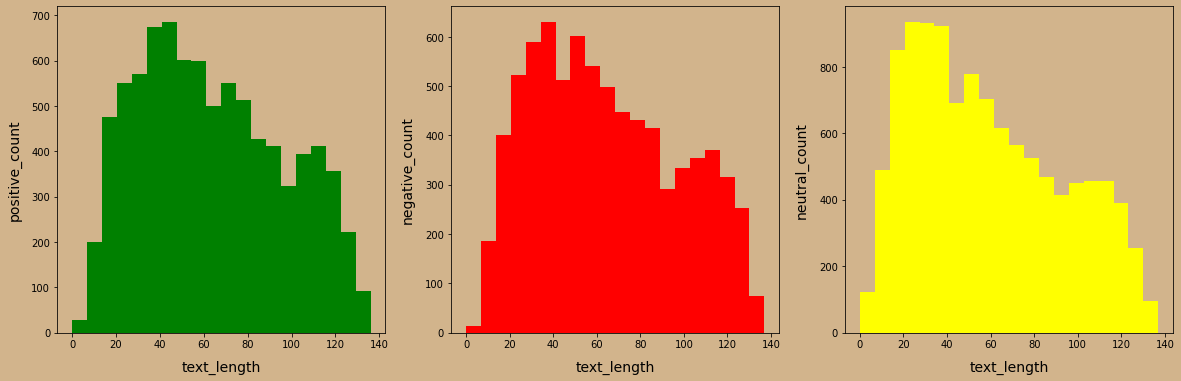

In [ ]:
#https://www.geeksforgeeks.org/plotting-histogram-in-python-using-matplotlib/
fig,ax=plt.subplots(1,3,figsize=(20,6))
ax[0].hist(pos['text_length'],bins=20,color='green')
ax[0].set_facecolor("tan")
ax[0].set_ylabel('positive_count',fontsize=14,labelpad=10)
ax[0].set_xlabel('text_length',fontsize=14,labelpad=10)

ax[1].hist(neg['text_length'],bins=20,color='red')
ax[1].set_facecolor("tan")
ax[1].set_ylabel('negative_count',fontsize=14,labelpad=10)
ax[1].set_xlabel('text_length',fontsize=14,labelpad=10)

ax[2].hist(neutral['text_length'],bins=20,color='yellow')
ax[2].set_facecolor("tan")
ax[2].set_ylabel('neutral_count',fontsize=14,labelpad=10)
ax[2].set_xlabel('text_length',fontsize=14,labelpad=10)

fig.set_facecolor("tan")
plt.show()

* The histogram shows that the length of the cleaned text ranges maximum upto aprox. 140 characters.

* Postive tweets: Most of tweets have length in range 30 to 50.

* Negative tweets: Most of tweets have length in range 20 to 40.

* Neutral tweets: Most of tweets have length in range 20 to 40.

* Very less tweet of length greater than 130 in all categories.

* Very less tweet of length less than 10 in all categories.

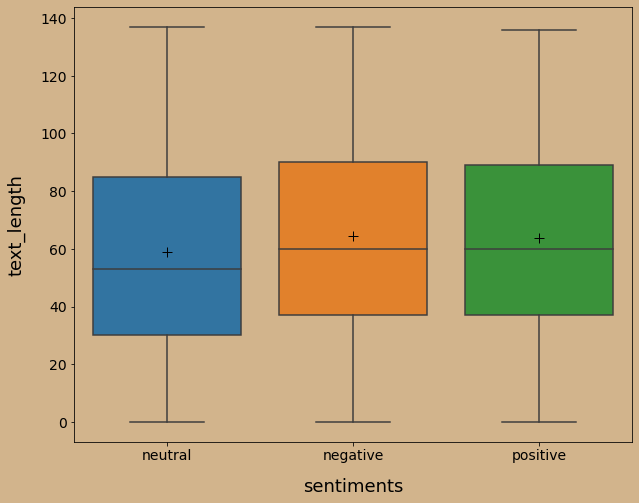

In [ ]:
fig,ax=plt.subplots(figsize=(10,8))
#https://www.geeksforgeeks.org/how-to-show-mean-on-boxplot-using-seaborn-in-python/
sns.boxplot(x='sentiment',y='text_length',data=train,showmeans=True,ax=ax,meanprops={"marker": "+","markeredgecolor": "black","markersize": "10"}) 
ax.set_ylabel('text_length',fontsize=18,labelpad=15)
ax.set_xlabel('sentiments',fontsize=18,labelpad=15)
plt.xticks(rotation='horizontal',fontsize=14)
plt.yticks(fontsize=14)
ax.set_facecolor("tan")
fig.set_facecolor("tan")
plt.show()

* All the text appear to have more or less same length. Hence length of the text is not a powerful indicator of the polarity.

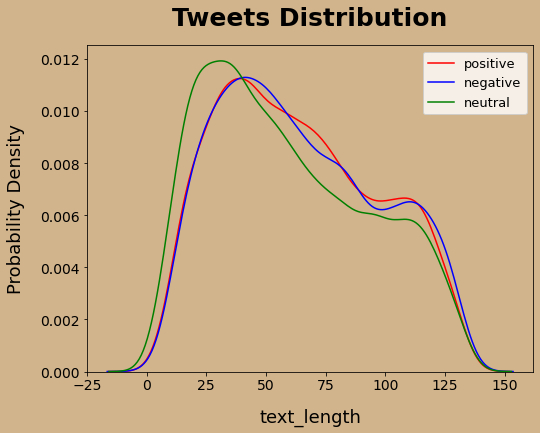

In [ ]:
#https://www.geeksforgeeks.org/kde-plot-visualization-with-pandas-and-seaborn/
fig,ax=plt.subplots(figsize=(8,6))
sns.kdeplot(train[train['sentiment']=='positive']['text_length'],color='r',Label='positive',ax=ax)
sns.kdeplot(train[train['sentiment']=='negative']['text_length'],color='b',Label='negative',ax=ax)
sns.kdeplot(train[train['sentiment']=='neutral']['text_length'],color='g',Label='neutral',ax=ax)
ax.set_title('Tweets Distribution',loc='center',fontsize=25,pad='20',fontweight='bold')
ax.set_ylabel('Probability Density',fontsize=18,labelpad=15)
ax.set_xlabel('text_length',fontsize=18,labelpad=15)
plt.xticks(rotation='horizontal',fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=13)
ax.set_facecolor("tan")
fig.set_facecolor("tan")
plt.show()

* Most of tweets have text word counts in range 25 to 60 for all categories.

* Very less tweet with length greater than 140.

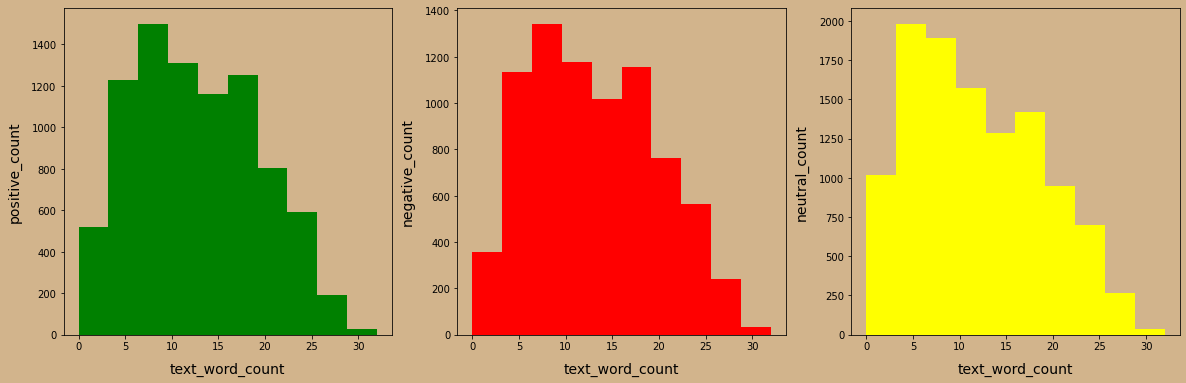

In [ ]:
#https://www.geeksforgeeks.org/plotting-histogram-in-python-using-matplotlib/
fig,ax=plt.subplots(1,3,figsize=(20,6))
ax[0].hist(pos['text_word_count'],bins=10,color='green')
ax[0].set_facecolor("tan")
ax[0].set_ylabel('positive_count',fontsize=14,labelpad=10)
ax[0].set_xlabel('text_word_count',fontsize=14,labelpad=10)

ax[1].hist(neg['text_word_count'],bins=10,color='red')
ax[1].set_facecolor("tan")
ax[1].set_ylabel('negative_count',fontsize=14,labelpad=10)
ax[1].set_xlabel('text_word_count',fontsize=14,labelpad=10)

ax[2].hist(neutral['text_word_count'],bins=10,color='yellow')
ax[2].set_facecolor("tan")
ax[2].set_ylabel('neutral_count',fontsize=14,labelpad=10)
ax[2].set_xlabel('text_word_count',fontsize=14,labelpad=10)

fig.set_facecolor("tan")
plt.show()

The histogram shows that the no. of text word counts ranges maximum upto aprox. 35 characters.

Postive tweets: Most of tweets have text word counts in range 5 to 15.

Negative tweets: Most of tweets have text word counts in range 5 to 15.

Neutral tweets: Most of tweets have text word counts in range 5 to 15.

Very less tweet of text word counts greater than 30 in all categories.

Very less tweet of text word counts less than 5 in all categories.

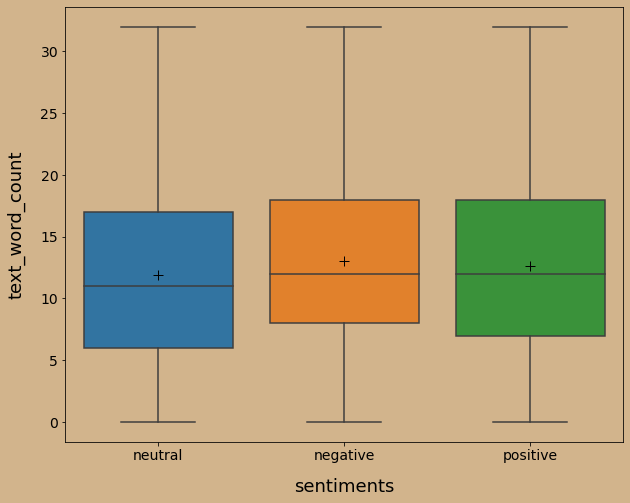

In [ ]:
fig,ax=plt.subplots(figsize=(10,8))
#https://www.geeksforgeeks.org/how-to-show-mean-on-boxplot-using-seaborn-in-python/
sns.boxplot(x='sentiment',y='text_word_count',data=train,showmeans=True,ax=ax,meanprops={"marker": "+","markeredgecolor": "black","markersize": "10"}) 
ax.set_ylabel('text_word_count',fontsize=18,labelpad=15)
ax.set_xlabel('sentiments',fontsize=18,labelpad=15)
plt.xticks(rotation='horizontal',fontsize=14)
plt.yticks(fontsize=14)
ax.set_facecolor("tan")
fig.set_facecolor("tan")
plt.show()

* All the text appear to have more or less same no. of word counts.


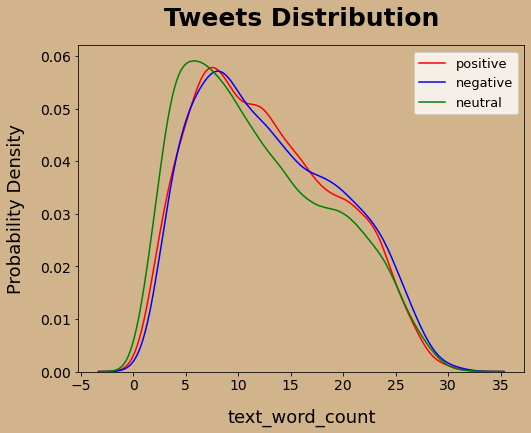

In [ ]:
#https://www.geeksforgeeks.org/kde-plot-visualization-with-pandas-and-seaborn/
fig,ax=plt.subplots(figsize=(8,6))
sns.kdeplot(train[train['sentiment']=='positive']['text_word_count'],color='r',Label='positive',ax=ax)
sns.kdeplot(train[train['sentiment']=='negative']['text_word_count'],color='b',Label='negative',ax=ax)
sns.kdeplot(train[train['sentiment']=='neutral']['text_word_count'],color='g',Label='neutral',ax=ax)
ax.set_title('Tweets Distribution',loc='center',fontsize=25,pad='20',fontweight='bold')
ax.set_ylabel('Probability Density',fontsize=18,labelpad=15)
ax.set_xlabel('text_word_count',fontsize=18,labelpad=15)
plt.xticks(rotation='horizontal',fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=13)
ax.set_facecolor("tan")
fig.set_facecolor("tan")
plt.show()

*  Most of tweets have text word counts in range 5 to 15 for all categories.

* Very less no. of word counts for range 30 to 35.

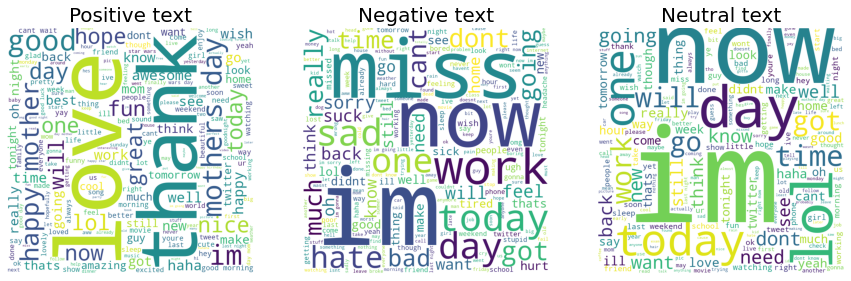

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(15,10))
stopwords = set(STOPWORDS)
wordcloud1 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(train[train['sentiment']=='positive']['text']))
 
# plot the WordCloud image                      
ax[0].imshow(wordcloud1)
ax[0].axis("off")
ax[0].set_title('Positive text',fontsize=20)

wordcloud2 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(train[train['sentiment']=='negative']['text']))
 
# plot the WordCloud image                      
ax[1].imshow(wordcloud2)
ax[1].axis("off")
ax[1].set_title('Negative text',fontsize=20)

wordcloud3 = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(" ".join(train[train['sentiment']=='neutral']['text']))
 
# plot the WordCloud image                      
ax[2].imshow(wordcloud3)
ax[2].axis("off")
ax[2].set_title('Neutral text',fontsize=20)

plt.show()

* The wordclouds give an idea of the words which might influence the polarity of the tweet.

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def top_n_words(corpus,n):
  vec=CountVectorizer(stop_words='english').fit(corpus)
  bag_of_words=vec.transform(corpus)
  sum_words=bag_of_words.sum(axis=0) 
  words_freq=[(word, sum_words[0,idx]) for word,idx in vec.vocabulary_.items()]
  words_freq=sorted(words_freq,key=lambda x: x[1], reverse=True)
  return(words_freq[:n])

# Common words for Text

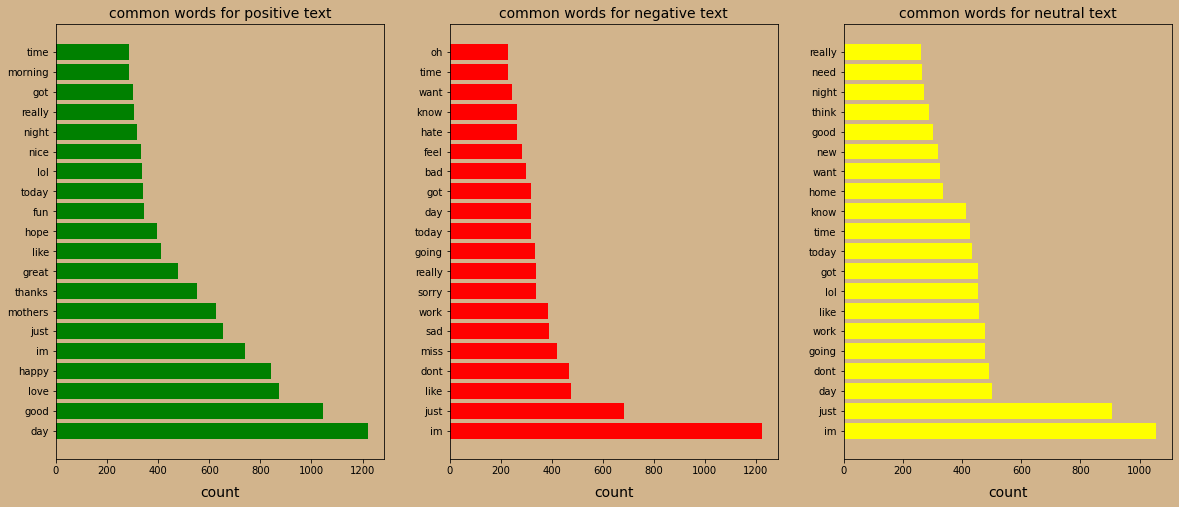

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,8))
d=top_n_words(pos['text'],20)
x_val=[x[0] for x in d]
y_val=[x[1] for x in d]
ax[0].barh(x_val,y_val,color ='green')
ax[0].set_title('common words for positive text',fontsize=14)
ax[0].set_xlabel('count',fontsize=14,labelpad=10)
ax[0].set_facecolor("tan")

d=top_n_words(neg['text'],20)
x_val=[x[0] for x in d]
y_val=[x[1] for x in d]
ax[1].barh(x_val,y_val,color ='red')
ax[1].set_title('common words for negative text',fontsize=14)
ax[1].set_xlabel('count',fontsize=14,labelpad=10)
ax[1].set_facecolor("tan")

d=top_n_words(neutral['text'],20)
x_val=[x[0] for x in d]
y_val=[x[1] for x in d]
ax[2].barh(x_val,y_val,color ='yellow')
ax[2].set_title('common words for neutral text',fontsize=14)
ax[2].set_xlabel('count',fontsize=14,labelpad=10)
ax[2].set_facecolor("tan")

fig.set_facecolor("tan")
plt.show()

# Common words for Selected Text

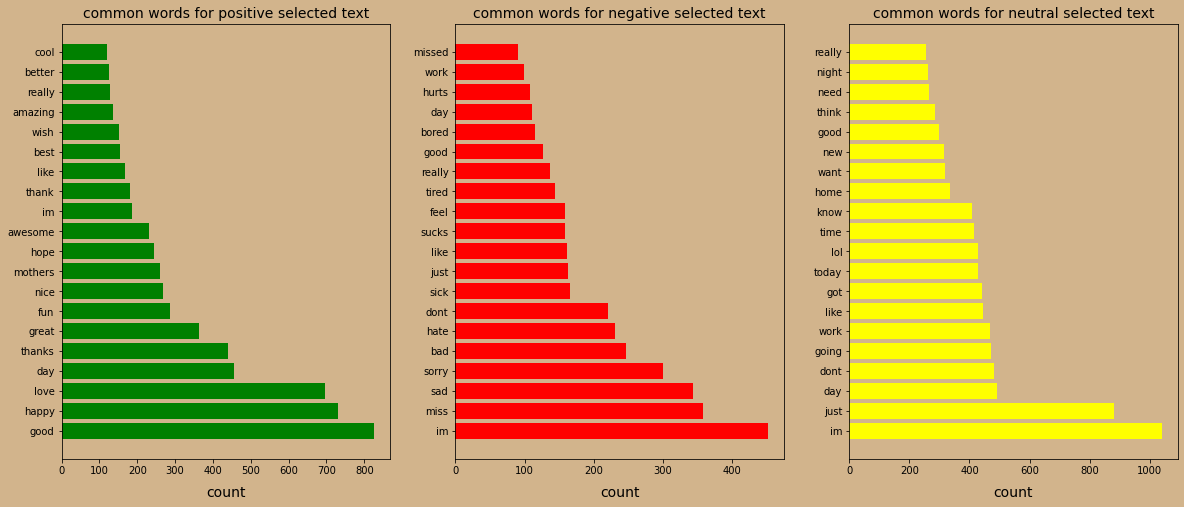

In [ ]:
fig,ax=plt.subplots(1,3,figsize=(20,8))
d=top_n_words(pos['selected_text'],20)
x_val=[x[0] for x in d]
y_val=[x[1] for x in d]
ax[0].barh(x_val,y_val,color ='green')
ax[0].set_title('common words for positive selected text',fontsize=14)
ax[0].set_xlabel('count',fontsize=14,labelpad=10)
ax[0].set_facecolor("tan")

d=top_n_words(neg['selected_text'],20)
x_val=[x[0] for x in d]
y_val=[x[1] for x in d]
ax[1].barh(x_val,y_val,color ='red')
ax[1].set_title('common words for negative selected text',fontsize=14)
ax[1].set_xlabel('count',fontsize=14,labelpad=10)
ax[1].set_facecolor("tan")

d=top_n_words(neutral['selected_text'],20)
x_val=[x[0] for x in d]
y_val=[x[1] for x in d]
ax[2].barh(x_val,y_val,color ='yellow')
ax[2].set_title('common words for neutral selected text',fontsize=14)
ax[2].set_xlabel('count',fontsize=14,labelpad=10)
ax[2].set_facecolor("tan")

fig.set_facecolor("tan")
plt.show()